In [1]:
from pyspark.sql import SparkSession
#from pyspark.sql.functions import *
from pyspark.sql import functions as F
#from googletrans import Translator
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
#from mpl_toolkits.basemap import Basemap
import time
import re

spark = SparkSession \
    .builder \
    .appName("Large scale human mobility data analysis through social media") \
    .config("spark.sql.broadcastTimeout", "36000") \
    .getOrCreate()

twitter_df = spark.read.load("/data/twitterdata/UserTweetInEurope_df.parquet", format="parquet")
twitter_ego = twitter_df.filter(twitter_df["text"].like("%@%"))
twitter_df.createOrReplaceTempView("twitter")

In [342]:
twitter_geotagged = twitter_df.filter(twitter_df['lat'].isNotNull())

In [346]:
4408531/25722574

0.17138763018040107

In [2]:
#extract all @mention from text and construct reciprocated network
def filter_all(x):
    result = re.findall('(\@)(\s|)+(\w+)(\\b)',x)
    return (','.join([i[2] for i in result]))
filter_all_udf = F.udf(filter_all)

twitter_ego = twitter_ego.withColumn('mention',filter_all_udf(twitter_ego['text']).alias('mention'))
twitter_ego.createOrReplaceTempView("twitter_ego")

twitter_ego1 = twitter_ego.select(F.explode(F.split(F.col("mention"),",")).alias("mention"),twitter_ego["user_name"],twitter_ego["media_id"])
twitter_ego1.createOrReplaceTempView("twitter_ego1")

twitter_ego2 = spark.sql("select user_name as source,mention as target,count(media_id) as weight from twitter_ego1 group by user_name,mention")
twitter_ego2.createOrReplaceTempView("twitter_ego2")
twitter_ego3 = spark.sql("select a.source,a.target as target1,b.target as target2,a.weight as weight1,b.weight as weight2 from twitter_ego2 a join twitter_ego2 b on a.target = b.source where a.source = b.target and a.source != a.target")
twitter_ego3 = twitter_ego3.withColumn('weight',F.least(twitter_ego3['weight1'], twitter_ego3['weight2']).alias("weight"))

twitter_ego3 = twitter_ego3.select(twitter_ego3['source'],twitter_ego3["target1"],twitter_ego3['weight'])
twitter_ego3.createOrReplaceTempView("twitter_ego3")

twitter_ego4 = spark.sql("select * from twitter where user_name in (select distinct source from twitter_ego3)")
twitter_ego4.createOrReplaceTempView("twitter_ego4")

In [2]:
import geocoder 
def geocode(list):
    for i in list:
        if i[1]==None:
            i[1]=None
        else:
            g=geocoder.google(i[1])
            if g.city == None:
                i[1]=None
            else:
                g.city_country='{},{}'.format(g.city,g.country)
                #g.city_country=g.city+g.country
                i[1]=[g.latlng,g.city_country]
                #time.sleep(10)
    print(list)
def reverse_geocode(list):
    for i in list:
        g = geocoder.google(i[1], method='reverse')
        g.city_country='{},{}'.format(g.city,g.country)
        i[1]=[i[1],g.city_country]
    print(list)

In [3]:
##ground_truth need to be revised, we should exclude user outside of Europe
##ground_truth1 from self-posted user profile locations
ground_truth1 = spark.read.csv('user_location.csv',header=True)
ground_truth1 = ground_truth1.dropDuplicates()
ground_truth1 = ground_truth1.withColumn('user_location',F.concat_ws(',', ground_truth1['user_city'], ground_truth1['user_country']).alias('user_location'))
ground_truth1 = ground_truth1.withColumn('lat',ground_truth1['lat'].cast(DoubleType()))
ground_truth1 = ground_truth1.withColumn('lon',ground_truth1['lon'].cast(DoubleType()))
ground_truth1 = ground_truth1.select(ground_truth1['user_name'],ground_truth1['lat'],ground_truth1['lon'],ground_truth1['user_location'])
######ground_truth1.filter(ground_truth1['user_country'].isin(['BE','BG','CZ','DK','DE','EE','IE','EL','ES','FR','HR','IT','CY','LV','LT','LU','HU','MT','NL','AT','PL','PT','RO','SI','SK','FI','SE','UK','IS','LI','NO','CH','ME','MK','AL','RS','TR','XK','BA'])).count()

In [4]:
##ground_truth2 from more than 3 geo-tagged tweets
geo_tagged = twitter_ego4.filter(twitter_ego4['lat'].isNotNull())
geo_tagged.createOrReplaceTempView("geo_tagged")
#restrict count to filter out skew data to prevent spark unefficency
geo_tagged = spark.sql('select user_name,media_id,followers_count,lat,lon,place_name,country_code from geo_tagged where place_type = "city" and user_id in (select user_id from geo_tagged group by user_id having count(distinct media_id)>= 3 and count(distinct media_id)< 500)')
geo_tagged = geo_tagged.withColumn('place_location',F.concat_ws(',', geo_tagged['place_name'], geo_tagged['country_code']).alias('place_location'))
geo_tagged = geo_tagged.select(geo_tagged['user_name'],geo_tagged['media_id'],geo_tagged['followers_count'],geo_tagged['lat'],geo_tagged['lon'],geo_tagged['place_location'])
geo_tagged.agg(F.countDistinct(geo_tagged['user_name'])).show()

+-------------------------+
|count(DISTINCT user_name)|
+-------------------------+
|                    10673|
+-------------------------+



In [9]:
geo_tagged_rdd = geo_tagged.rdd.map(lambda row : (row[0],row[1],row[2],row[3],row[4],row[5],None,None,None)).keyBy(lambda p : p[0]).groupByKey()
geo_tagged_rdd = geo_tagged_rdd.map(lambda x : (x[0], list(x[1])))
##the calculation for the dispersion of geo_tagged tweets, weight need to be removed
##Actually, it does not matter when we use followers_count to replace the weight
#since it is the same for all the points in Adjacency list.
geo_tagged_rdd = geo_tagged_rdd.map(lambda x : (x[0],dispersion(x[1])))
geo_tagged_rdd = geo_tagged_rdd.map(lambda x : (x[0],x[1][0],x[1][1],x[1][2],x[1][3]))
geo_tagged_rdd = geo_tagged_rdd.filter(lambda x : x[3]!= None)

#calculate the activity radius of geo_tagged users
geo_tagged_median = geo_tagged_rdd.map(lambda x : x[4]).collect() 

geo_tagged_df = geo_tagged_rdd.filter(lambda x : x[4]<30.0).toDF()
ground_truth2 = geo_tagged_df.select(geo_tagged_df['_1'].alias('user_name'),geo_tagged_df['_2'].alias('lat'),geo_tagged_df['_3'].alias('lon'),geo_tagged_df['_4'].alias('user_location'))

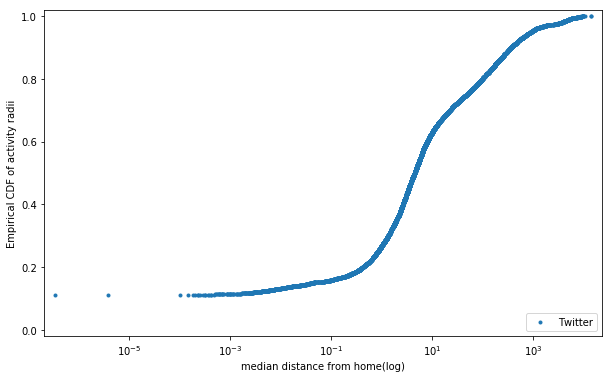

In [14]:
plt.rcParams["figure.figsize"] = (10, 6)
x = np.sort(geo_tagged_median)
y = np.arange(1,len(x)+1)/len(x)
#histogram_cumulative
#plt.hist(geo_tagged_median,normed=True, cumulative=True, label='CDF', histtype='step', alpha=0.8, color='C0')
plt.plot(x,y,marker='.',linestyle='none')
plt.xlabel('median distance from home(log)')
plt.ylabel('Empirical CDF of activity radii')
plt.xscale('log')
plt.legend(['Twitter'], loc='lower right')
plt.margins(0.02)
plt.savefig('../Figures/Empirical_CDF_of_activity_radii1.eps', format='eps',bbox_inches='tight',transparent=True)

In [7]:
#calculate the median distance to friends of geo_tagged users
#filter network with only ground_truth2 users, 'inner' join but not 'left' join
networkWithLocations_ground= twitter_ego3.join(ground_truth2,twitter_ego3['source'] == ground_truth2['user_name']).drop(ground_truth2["user_name"])
networkWithLocations_ground = networkWithLocations_ground.select(networkWithLocations_ground['source'],networkWithLocations_ground['target1'].alias('target'),networkWithLocations_ground['weight'],networkWithLocations_ground['user_location'].alias('source_location'),networkWithLocations_ground['lat'].alias('source_lat'),networkWithLocations_ground['lon'].alias('source_lon'))
networkWithLocations_ground = networkWithLocations_ground.join(ground_truth2,networkWithLocations_ground['target'] == ground_truth2['user_name']).drop(ground_truth2["user_name"])
networkWithLocations_ground = networkWithLocations_ground.select(networkWithLocations_ground['source'],networkWithLocations_ground['target'],networkWithLocations_ground['weight'],networkWithLocations_ground['lat'].alias('target_lat'),networkWithLocations_ground['lon'].alias('target_lon'),networkWithLocations_ground['user_location'].alias('target_location'),networkWithLocations_ground['source_lat'],networkWithLocations_ground['source_lon'],networkWithLocations_ground['source_location'])
adjListWithLocations_ground = networkWithLocations_ground.rdd.map(lambda row : (row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8])).keyBy(lambda p : p[0]).groupByKey()
user_location_list_ground = adjListWithLocations_ground.map(lambda x : (x[0], list(x[1])))
user_location_list_ground  = user_location_list_ground.map(lambda x : (x[0],dispersion(x[1])))
user_location_list_ground  = user_location_list_ground.map(lambda x : (x[0],x[1][0],x[1][1],x[1][2],x[1][3]))
user_median_distance_to_friend = user_location_list_ground.map(lambda x:x[4]).collect()

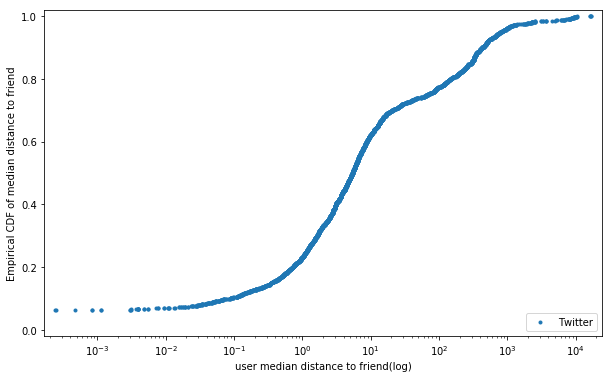

In [15]:
plt.rcParams["figure.figsize"] = (10, 6)
x = np.sort(user_median_distance_to_friend)
y = np.arange(1,len(x)+1)/len(x)
#histogram_cumulative
#plt.hist(geo_tagged_median,normed=True, cumulative=True, label='CDF', histtype='step', alpha=0.8, color='C0')
plt.plot(x,y,marker='.',linestyle='none')
plt.xlabel('user median distance to friend(log)')
plt.ylabel('Empirical CDF of median distance to friend')
plt.xscale('log')
plt.legend(['Twitter'], loc='lower right')
plt.margins(0.02)
plt.savefig('../Figures/User_median_distance_to_friend1.eps', format='eps',bbox_inches='tight',transparent=True)

In [11]:
#when user is in both ground truth1 and ground truth2, then choose the result of ground truth2
ground_truth1.createOrReplaceTempView("ground_truth1")
ground_truth2.createOrReplaceTempView("ground_truth2")
ground_truth1 = spark.sql('select * from ground_truth1 where user_name not in (select user_name from ground_truth2)')
ground_truth = ground_truth1.unionAll(ground_truth2)
#ground_truth.count()

In [227]:
coverage_list= []
coverage_percentage_list = []
error_median_list = []
error_mean_list = []
for j in range(1,11):    
    ground_truth_sample = ground_truth2.sample(False, 0.1)
    ground_truth_sample.createOrReplaceTempView("ground_truth_sample")
    ground_truth.createOrReplaceTempView("ground_truth")
    ground_truth_final = spark.sql("select * from ground_truth where user_name not in (select user_name from ground_truth_sample)")
    #ground_truth_sample.count()
    for i in range(1,6):
        networkWithLocations = twitter_ego3.join(ground_truth_final,twitter_ego3['target1'] == ground_truth_final['user_name'],'left').drop(ground_truth_final["user_name"])
        networkWithLocations = networkWithLocations.select(networkWithLocations['source'],networkWithLocations['target1'].alias('target'),networkWithLocations['weight'],networkWithLocations['user_location'].alias('target_location'),networkWithLocations['lat'].alias('target_lat'),networkWithLocations['lon'].alias('target_lon'))
        networkWithLocations = networkWithLocations.join(ground_truth_final,networkWithLocations['source'] == ground_truth_final['user_name'],'left').drop(ground_truth_final["user_name"])
        networkWithLocations = networkWithLocations.select(networkWithLocations['source'],networkWithLocations['target'],networkWithLocations['weight'],networkWithLocations['target_lat'],networkWithLocations['target_lon'],networkWithLocations['target_location'],networkWithLocations['lat'].alias('source_lat'),networkWithLocations['lon'].alias('source_lon'),networkWithLocations['user_location'].alias('source_location'))
        adjListWithLocations = networkWithLocations.rdd.map(lambda row : (row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8])).keyBy(lambda p : p[0]).groupByKey()
    
        user_location_list = adjListWithLocations.map(lambda x : (x[0], list(x[1])))

        user_location_list = user_location_list.map(lambda x : (x[0],dispersion(x[1])))
        user_location_list = user_location_list.map(lambda x : (x[0],x[1][0],x[1][1],x[1][2],x[1][3]))
        #user_location_list = user_location_list.filter(lambda x : x[3]!= None).toDF()
        user_location_list = user_location_list.filter(lambda x : x[4]<100.0).toDF()
        #location_df = user_location_list.toDF()
        ground_truth_final= user_location_list.select(user_location_list['_1'].alias('user_name'),user_location_list['_2'].alias('lat'),user_location_list['_3'].alias('lon'),user_location_list['_4'].alias('user_location'))
        #print(i)
        print(ground_truth_final.count())
    ########
    #leave-many-out cross-validation
    ground_truth_sample = ground_truth_sample.select(ground_truth_sample['user_name'],ground_truth_sample['lat'].alias('lat_sample'),ground_truth_sample['lon'].alias('lon_sample'),ground_truth_sample['lon'].alias('user_location_sample'))
    sample = ground_truth_sample.join(ground_truth_final,ground_truth_sample['user_name'] == ground_truth_final['user_name'],'left').drop(ground_truth_final['user_name'])
    sample = sample.filter(sample['user_location'].isNotNull())
    coverage_list.append(sample.count())
    coverage_percentage_list.append(sample.count()/ground_truth_sample.count())
    sample = sample.withColumn('error',dist(sample['lon_sample'],sample['lat_sample'],sample['lon'],sample['lat']))
    error = sample.select('error').rdd.map(lambda x : x[0]).collect()
    error_median = np.median(error)
    error_mean = np.mean(error)
    error_median_list.append(error_median)
    error_mean_list.append(error_mean)

74260
75102
75177
75328
75326
74312
75081
75218
75323
75349
74278
75106
75221
75335
75347
74265
75082
75184
75349
75311
74292
75073
75197
75329
75330
74320
75089
75254
75332
75338
74296
75104
75150
75327
75269
74283
75111
75197
75334
75327
74308
75068
75213
75291
75311
74291
75086
75212
75308
75326


In [5]:
import math
def distance(lon1, lat1,lon2,lat2):
    radius = 6371 # km
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

def dist(lon1, lat1, lon2, lat2):
    radius = 6371  # km
    dlat = F.radians(lat2 - lat1)
    dlon = F.radians(lon2 - lon1)
    a = F.sin(dlat / 2) * F.sin(dlat / 2) + F.cos(F.radians(lat1)) \
        * F.cos(F.radians(lat2)) * F.sin(dlon / 2) * F.sin(dlon / 2)
    c = 2 * F.atan2(F.sqrt(a), F.sqrt(1 - a))
    d = radius * c
    return d

def l1median(list):
    min = float("inf")
    user_location = None
    user_lat = None
    user_lon = None
    for i in list:
        #i[8] is source_location,ground_truth
        if i[8]!= None:
            user_location = i[8]
            user_lat = i[6]
            user_lon = i[7]
        #i[3] is target_lat,i[4] is target_lon
        elif (i[3]!=None)&(i[4]!=None):
            list1 = list[:]
            list1.remove(i)
            dist = 0.0
            for j in list1:
                #j[3] is target_lat
                if j[3]!= None:
                    #j[2] is weight,j[4] is target_lon and j[3] is source_lon
                    #d = distance(j[4],j[3],i[4],i[3])
                    d = j[2]*distance(j[4],j[3],i[4],i[3])
                    dist = d + dist
            if dist < min:
                min = dist
                user_location = i[5]
                user_lat = i[3]
                user_lon = i[4]
        else:
            continue
    return((i[0],user_lat,user_lon,user_location))

def dispersion(list):
    home = l1median(list)
    user_lat = home[1]
    user_lon = home[2]
    user_location = home[3]
    absolute_deviation = []
    median = 0.0
    if (user_lat != None)&(user_lon!=None):
        #i[8] is source_location,ground_truth
        if list[0][8]== user_location:
            for j in list:
                if j[3]!= None:
                    d = distance(j[4],j[3],user_lon,user_lat)
                    absolute_deviation.append(d)
            if len(absolute_deviation)!=0:
                median = np.median(absolute_deviation)
            else:
                median = 0.0
        else:
            for i in list:
                #i[5] is target_location
                if (i[3] == user_lat) & (i[4] == user_lon):
                    list1 = list[:]
                    list1.remove(i)
                    for j in list1:
                        if j[3]!= None:
                            d = distance(j[4],j[3],i[4],i[3])
                            absolute_deviation.append(d)
                    if len(absolute_deviation)!=0:
                        median = np.median(absolute_deviation)
                    else:
                        median = 0.0
                else:
                    continue
    return(user_lat,user_lon,user_location,float(median))

In [18]:
import numpy as np
from scipy import stats


a = np.asarray(error_median_list1)
b = np.asarray(error_median_list1)

#Paired sample T-test
#Calculate the T-test on TWO RELATED samples of scores, a and b.
t,p = stats.ttest_rel(a,b)
print("t = " + str(t))
print("p = " + str(p))

t = 3.22159056915
p = 0.191607104911


In [249]:
import numpy as np
from scipy import stats

a = [8.0967557805918613,
 8.275997135357489,
 7.8061025797261703,
 9.3117782856156328,
 7.3946106686716337,
 13.055172685735103,
 9.3063331261043167,
 8.0967557805918613,
 8.3194758270834814,
 10.839153443304374]
b = [8.5933784708059999,
 6.0943795008453998,
 7.9597584399428065,
 10.839153443304374,
 8.1383529608792688,
 12.598511525170732,
 7.6112657884080805,
 8.0240204067354206,
 8.9559577611689818,
 8.7141425134524655]
a = np.asarray(a)
b = np.asarray(b)

#Paired sample T-test
#Calculate the T-test on TWO RELATED samples of scores, a and b.
t,p = stats.ttest_rel(a,b)
print("t = " + str(t))
print("p = " + str(p))

t = 0.727326632353
p = 0.485514506304


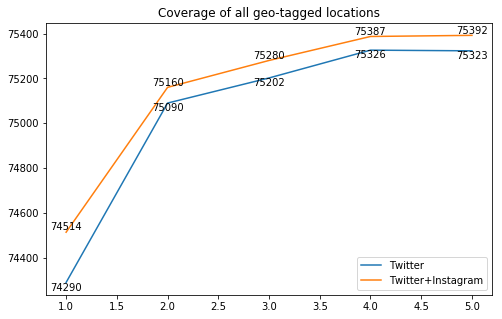

In [265]:
plt.rcParams["figure.figsize"] = (8, 5)
x = [1,2,3,4,5]
z1 = round((74260+74312+74278+74265+74292+74320+74296+74283+74308+74291)/10)
z2 = round((75102+75081+75106+75082+75073+75089+75104+75111+75068+75086)/10)
z3 = round((75177+75218+75221+75184+75197+75254+75150+75197+75213+75212)/10)
z4 = round((75328+75323+75335+75349+75329+75332+75327+75334+75291+75308)/10)
z5 = round((75326+75349+75347+75311+75330+75338+75269+75327+75311+75326)/10)

z6 = round((74486+74519+74519+74518+74528+74530+74527+74492+74482+74543)/10)
z7 = round((75148+75155+75132+75208+75123+75174+75180+75161+75181+75135)/10)
z8 = round((75265+75290+75291+75286+75301+75296+75279+75260+75253+75277)/10)
z9 = round((75369+75385+75373+75388+75366+75395+75373+75408+75415+75398)/10)
z10 = round((75360+75361+75392+75423+75390+75397+75405+75399+75385+75403)/10)
y1 = [z1,z2,z3,z4,z5]
y2 = [z6,z7,z8,z9,z10]
plt.plot(x,y1)
plt.plot(x,y2)
for a, b in zip(x,y1):
    plt.text(a, b, str(b), ha='center', va='top')
for a, b in zip(x,y2):
    plt.text(a, b, str(b), ha='center', va='bottom')
plt.legend(['Twitter', 'Twitter+Instagram'], loc='lower right')
plt.title("Coverage of all geo-tagged locations")
plt.savefig('../Figures/Coverage.eps', format='eps',bbox_inches='tight',transparent=True)